## Importing Data and necessary libraries ##

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
plt.style.use('ggplot')
import numpy as np
import seaborn as sns
from random import seed
from random import randint
import scipy.stats as stats
from scipy.stats import chi2_contingency, f_oneway, pearsonr, ttest_ind 
import statsmodels.formula.api as sm
from statsmodels.stats.anova import anova_lm
import os 

In [9]:
df = pd.read_excel(r'C:\Users\Yassine Ben El Haj\Desktop\mydata.xlsx')

## Data preprocessing ##

In [117]:
# Exploring the data

df.describe(include=["object", "bool", "datetime"])

df.count()
df.info
### Rename some columns for better readability 

df.rename(columns={'Account Creation Initiated' : 'account_creation_initiated',
       'Registration Date' : 'reg_date', 'Email Verification Started': 'email_verification_sta',
       'Email Verification Completed' : 'email_verification_com', 'Profile Setup Started': 'profile_setup_sta',
       'Profile Setup Completed': 'profile_setup_com', 'Feature Tutorial Started': 'feature_tuto_sta',
       'Feature Tutorial Completed': 'feature_tuto_com', 'First Feature Introduction': 'first_feat_intro',
       'First Action Taken': 'first_act_tak','Getting Started Page Views': 'getting_sta', 'Account Management Page Views': 'acc_manag',
       'Audio and Video Page Views': 'aud_vid', 'Integration Page Views': 'integration', 'Demographics': 'geographics',
       'Signup Source': 'sign_source', 'Subscription Type': 'sub_type'}, inplace=True
       )

### Checking & Removing Duplicates ###
df.duplicated()

# Checking for duplicated User Ids
df['user_id'].duplicated()  

# Sort by Registration date (ascending)
sorted_df = df.sort_values(by='reg_date', ascending= True)  

# Dropping the duplicated User Ids and keep only the first registred user ids
user_df = sorted_df.drop_duplicates(subset='user_id', keep='first')

### Checking for missing values

df.isnull().sum()

## COMMENT: 
# In our dataset, the missing values are primarily related to timestamps.
# In this analysis context, they are representing different user actions,
# such as email verification, profile setup, feature tutorial completion, and so on
# Leaving them empty preserves the original data and avoids bias from imputing values or dropping rows. 
# This transparency (users with/without actions) allows for easier analysis and filtering based on engagement.



user_id                         0
is_new_user                     0
account_creation_initiated      0
reg_date                        0
email_verification_sta          0
email_verification_com        238
profile_setup_sta             238
profile_setup_com             238
feature_tuto_sta              238
feature_tuto_com              594
first_feat_intro              594
first_act_tak                 654
sec_fea_intro                   0
sec_fea_interaction             0
getting_sta                     0
acc_manag                       0
aud_vid                         0
integration                     0
geographics                     0
sign_source                     0
sub_type                        0
feed_score                      0
dtype: int64

In [11]:
df.head(5)

,user_id,is_new_user,account_creation_initiated,reg_date,email_verification_sta,email_verification_com,profile_setup_sta,profile_setup_com,feature_tuto_sta,feature_tuto_com,...,sec_fea_intro,sec_fea_interaction,getting_sta,acc_manag,aud_vid,integration,geographics,sign_source,sub_type,feed_score
0,user_531,1,1,2024-01-30,2024-01-30 00:03:04.745,NaT,NaT,NaT,2023-10-03 01:00:40.460,NaT,...,1,1,16,15,16,1,JAPAN,Social Media,Basic,0
1,user_776,1,1,2023-10-03,2023-10-03 00:02:21.852,2023-10-03 00:07:37.754,2023-10-03 00:20:10.990,2023-10-03 00:37:29.440,2023-10-31 01:10:54.192,2023-10-31 01:40:35.638,...,1,1,19,1,23,7,EUROPE,Advertisement,Pro,0
2,user_919,0,1,2023-10-31,2023-10-31 00:04:39.465,2023-10-31 00:14:26.547,2023-10-31 00:28:26.463,2023-10-31 00:48:00.179,2023-08-14 00:57:43.253,NaT,...,1,0,11,10,20,8,UK,Advertisement,Basic,4
3,user_723,0,1,2023-08-14,2023-08-14 00:04:08.268,2023-08-14 00:11:54.352,2023-08-14 00:22:05.355,2023-08-14 00:37:26.580,2023-09-13 01:03:48.684,2023-09-13 01:30:08.440,...,1,0,6,13,19,10,JAPAN,Website,Business,5
4,user_213,0,1,2024-03-11,2024-03-11 00:03:06.671,NaT,NaT,NaT,2024-02-23 01:03:24.844,NaT,...,0,1,16,5,7,7,UK,Social Media,Enterprise,4


# Visualization of New and Returning Users Over Time

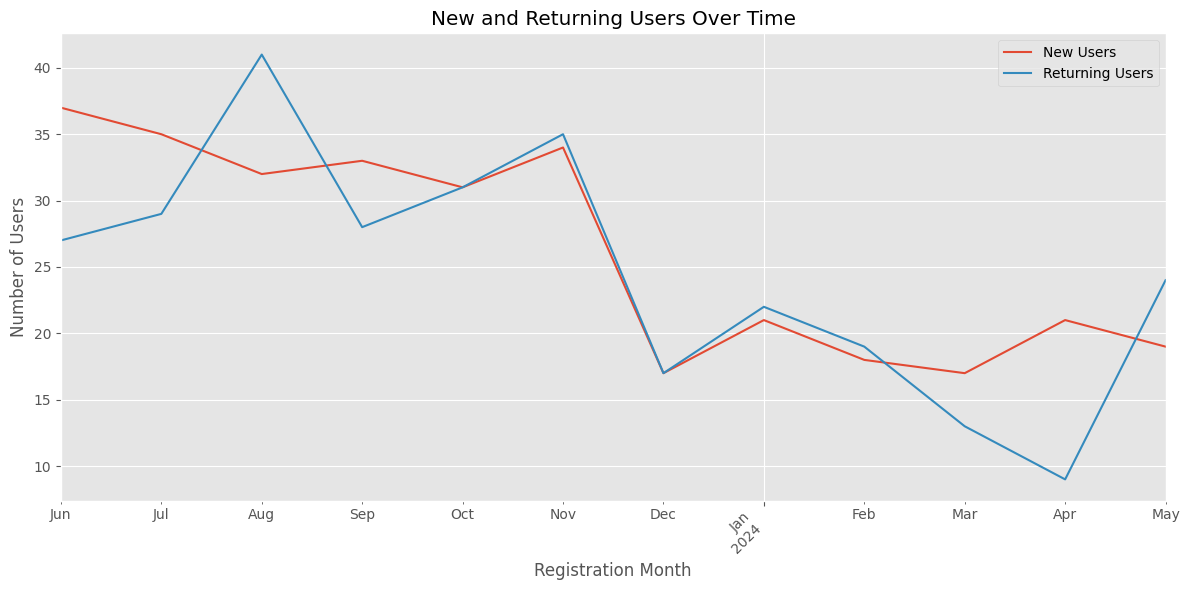

In [132]:

new_users_by_month = user_df.groupby(pd.to_datetime(user_df['reg_date']).dt.to_period('M'))['is_new_user'].sum()
returning_users_by_month = user_df.groupby(pd.to_datetime(df['reg_date']).dt.to_period('M'))['is_new_user'].count() - new_users_by_month

# Create the time series chart
fig, ax = plt.subplots(figsize=(12, 6))
new_users_by_month.plot(kind='line', ax=ax, label='New Users')
returning_users_by_month.plot(kind='line', ax=ax, label='Returning Users')

plt.title('New and Returning Users Over Time')
plt.xlabel('Registration Month')
plt.ylabel('Number of Users')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



#Visualize User type distribution

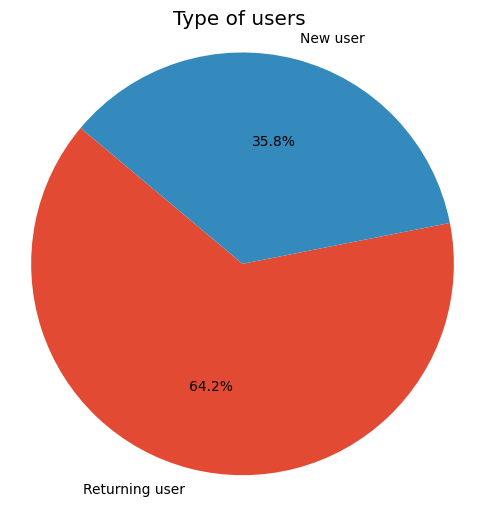

In [140]:
def pie_chart(is_new_user):
  user_counts = user_df[is_new_user].value_counts().reset_index()
  user_counts.columns = ['User Type', 'Count']
  user_counts['User Type'] = user_counts['User Type'].replace({1: "New user", 0: "Returning user"})
  
  plt.figure(figsize=(6,6))
  plt.pie(user_counts['Count'], labels=user_counts['User Type'], autopct='%1.1f%%', startangle=140)
  plt.title(f'Type of users ')
  plt.axis('equal')
  plt.show()

pie_chart('is_new_user')

In [103]:
df.columns

Index(['user_id', 'is_new_user', 'account_creation_initiated', 'reg_date',
       'email_verification_sta', 'email_verification_com', 'profile_setup_sta',
       'profile_setup_com', 'feature_tuto_sta', 'feature_tuto_com',
       'first_feat_intro', 'first_act_tak', 'sec_fea_intro',
       'sec_fea_interaction', 'getting_sta', 'acc_manag', 'aud_vid',
       'integration', 'geographics', 'sign_source', 'sub_type', 'feed_score'],
      dtype='object')

In [133]:
selected_columns= ['is_new_user', 'email_verification_sta',
                   'email_verification_com', 'profile_setup_sta',
                   'profile_setup_com', 'feature_tuto_sta', 'feature_tuto_com',
                   'first_feat_intro', 'first_act_tak', 'sec_fea_intro',
                   'sec_fea_interaction', 'getting_sta', 'acc_manag', 'aud_vid',
                   'integration', 'geographics', 'sign_source', 'sub_type', 'feed_score']


df_subset = user_df.loc[:,selected_columns]

#converting categorical columns to num using one-hot encoding
df_encoded = pd.get_dummies(df_subset, columns= ['geographics', 'sign_source', 'sub_type'])
#correlation table
visual_columns = df_encoded.columns
correlation_matrix = df_encoded[visual_columns].corr()


#Visualize the correlation matrix

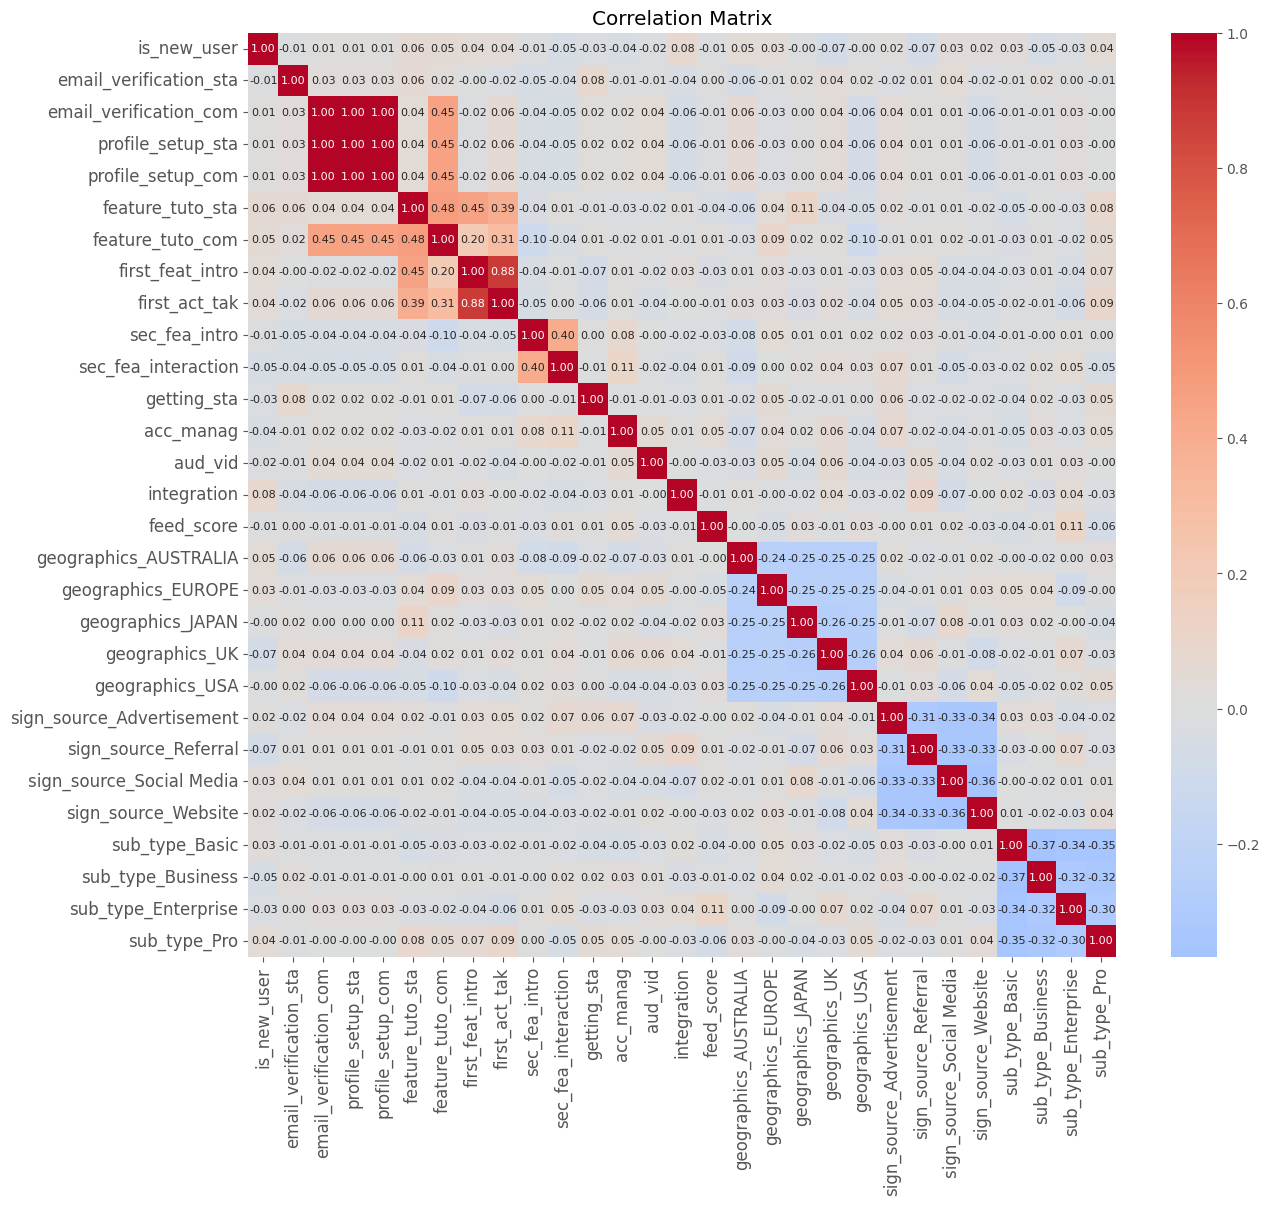

In [134]:
plt.figure(figsize= (14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap = 'coolwarm', center=0, annot_kws={"size": 8}, fmt=".2f")
plt.title('Correlation Matrix')
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize= 12)                                                                             
plt.show()

## Visualize user Geographics distribution

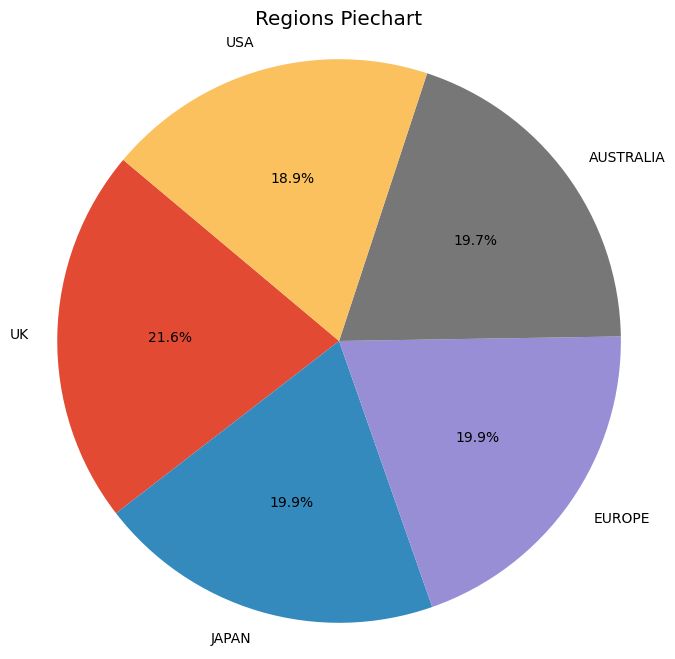

In [136]:
def pie_chart(geographics):
  counts = df[geographics].value_counts()

  plt.figure(figsize=(8,8))
  plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
  plt.title(f'Regions Piechart')
  plt.axis('equal')
  plt.show()

pie_chart('geographics')

#Pairwise Relationships 

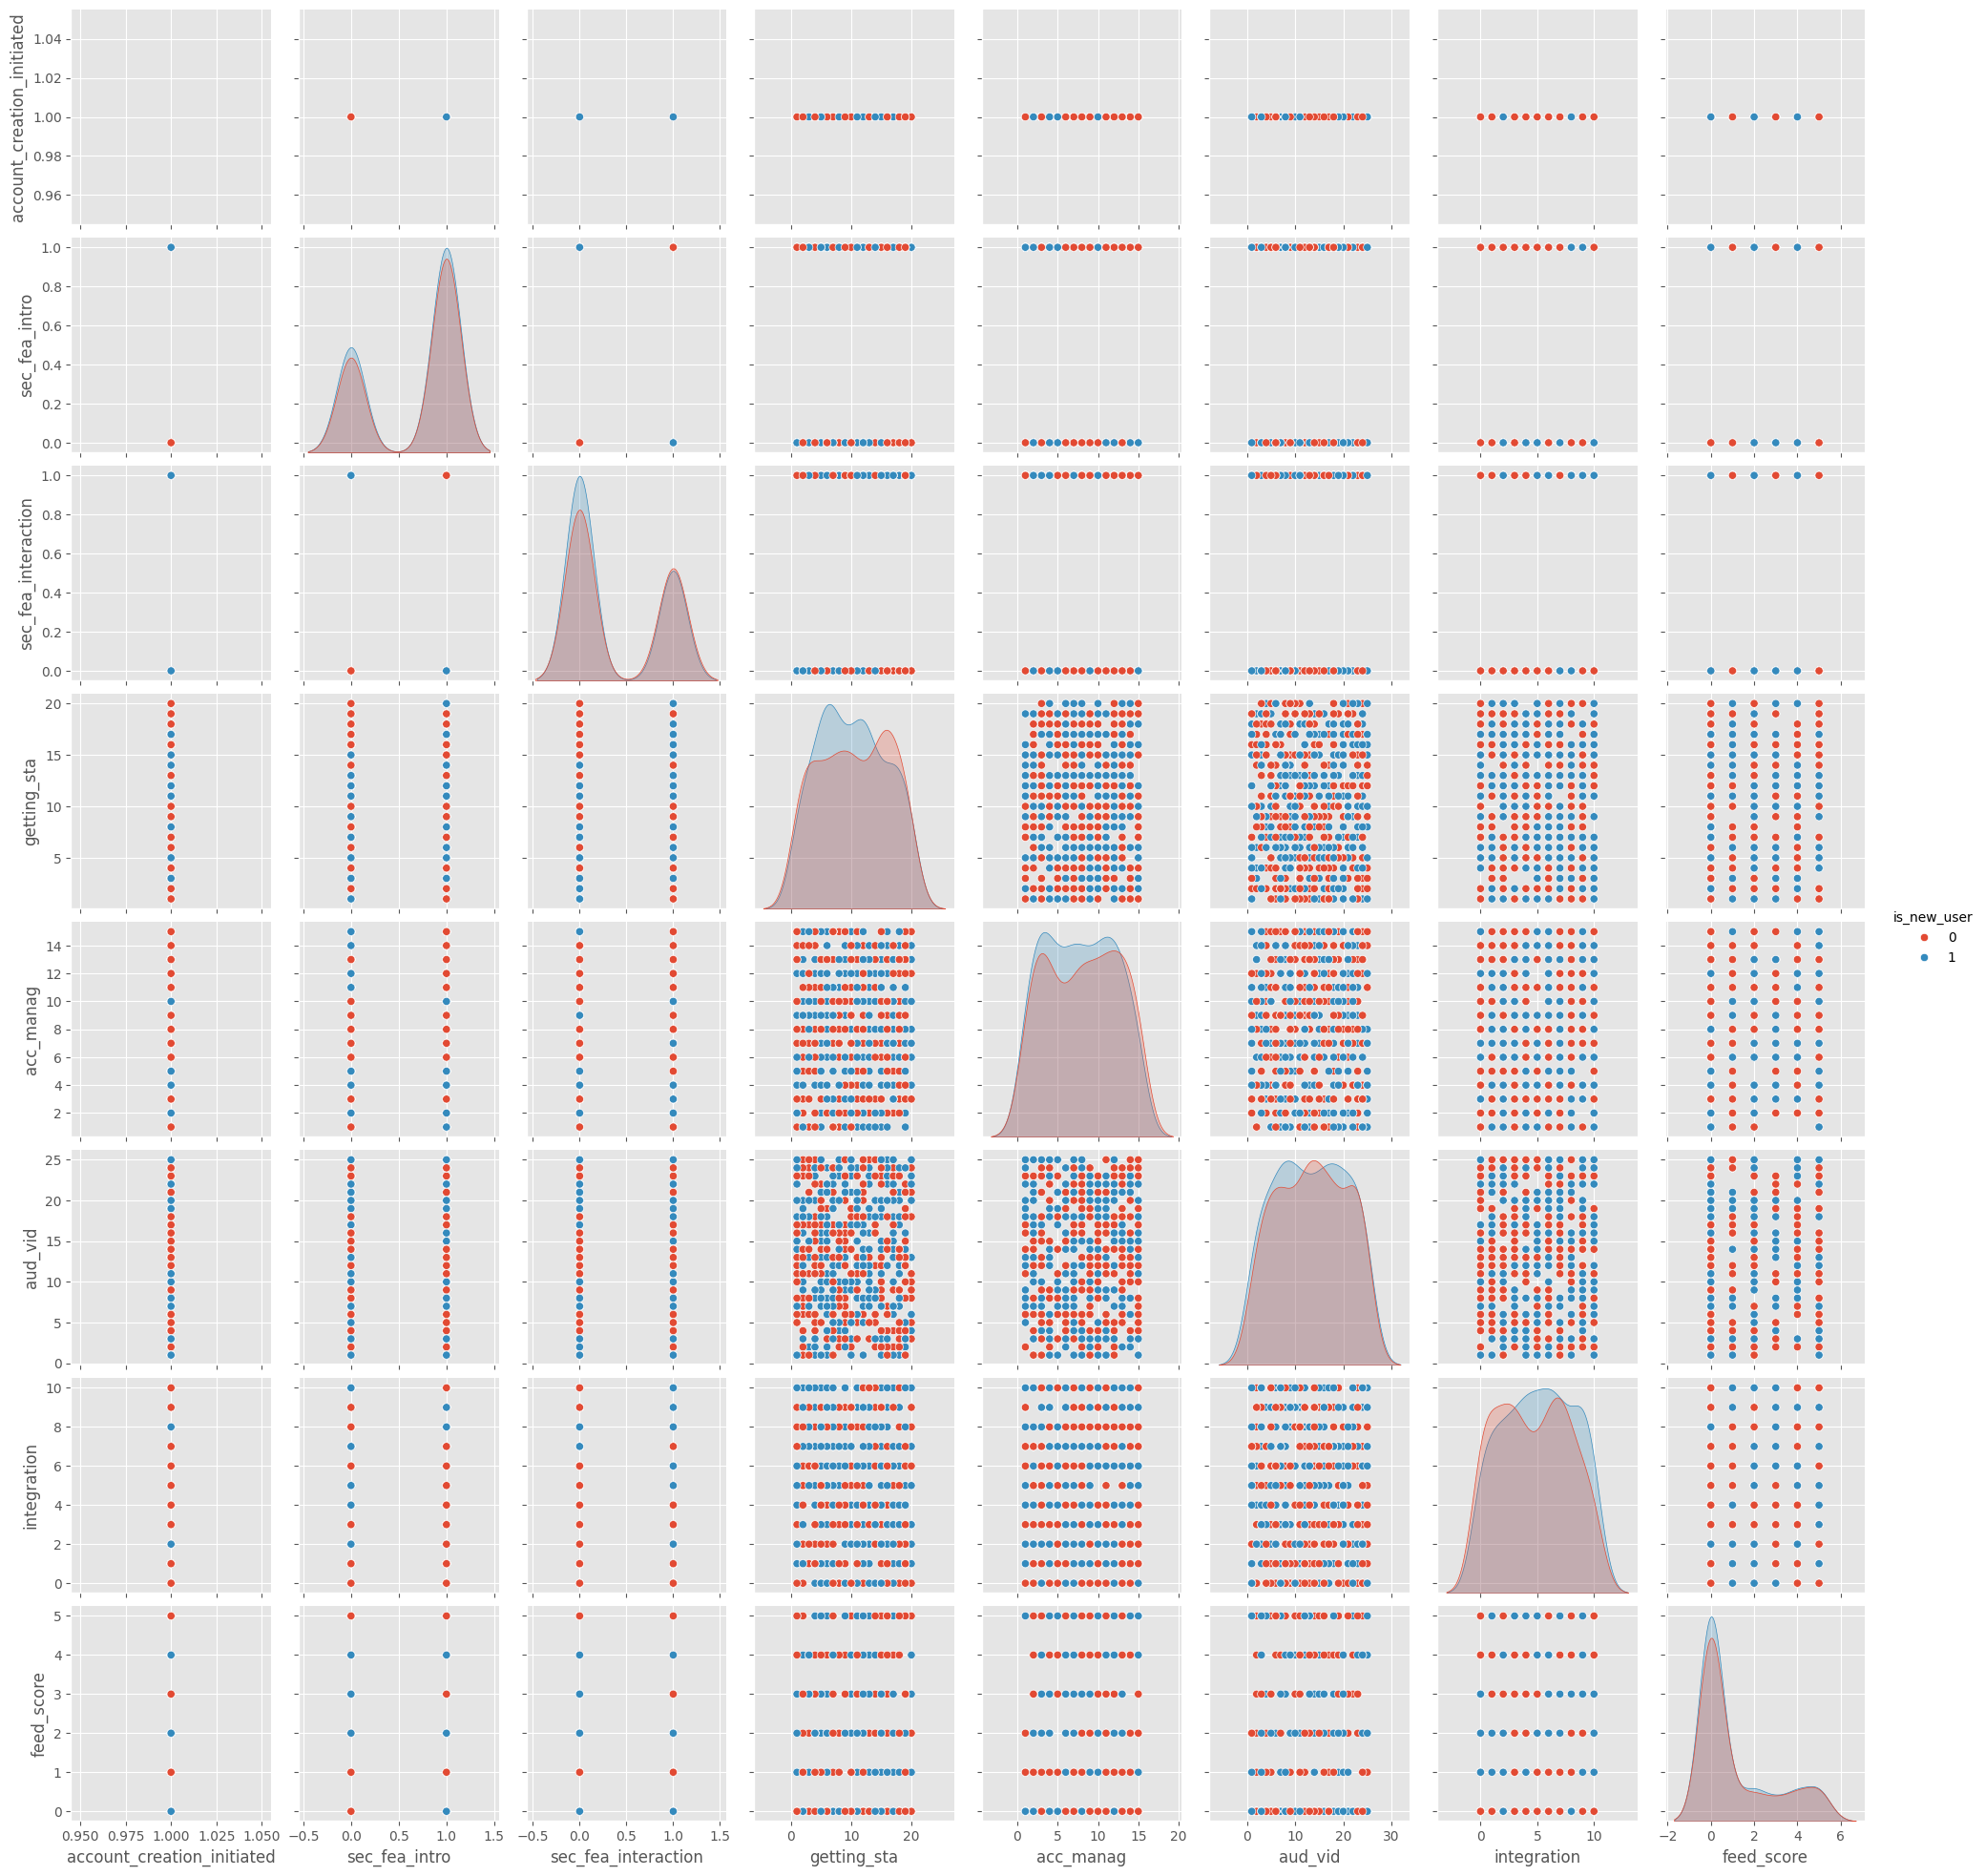

In [151]:
for col in ['sub_type', 'sign_source', 'is_new_user', 'geographics', 'first_act_tak']:
    user_df.loc[:, col] = user_df[col].astype('category')

cat_columns = user_df.select_dtypes(['category']).columns

# Finally, we transform the original columns by replacing the elements with their category codes:
user_df[cat_columns] = user_df[cat_columns].apply(lambda x: x.cat.codes)

sns.pairplot(user_df, hue  = 'is_new_user')
plt.show()

# Let's try answering some question

In [ ]:
     #### Drop-off stages: Analyze at which steps users are dropping off by calculating the completion rates ##


In [15]:

# Account verification Compelation rate # STAGE 1 #

# Filter rows with valid values in "email verification com" (exclude NaT)
filtered_email = user_df[~user_df['email_verification_com'].isna()]

# Count the number of rows in the filtered DataFrame
email_verified_count = filtered_email.shape[0]

# Total accounts created 
total_accounts_created = user_df.shape[0]

# Calculate the verification rate
account_verification_rate = (email_verified_count / total_accounts_created) * 100
print(f"Verification Compelation rate : {account_verification_rate:.2f}%")

# Profile Setup Compelation rate   # STAGE 2 #

filtered_pro_com = user_df[~user_df['profile_setup_com'].isna()]
profil_set_com_count = filtered_pro_com.shape[0]
total_accounts_created = user_df.shape[0]
profile_setup_rate = (profil_set_com_count / total_accounts_created) * 100
print(f"Profile Setup Compelation : {profile_setup_rate:.2f}%")

# Feature Tutorial Completed   # STAGE 3 #
filtered_feat_tut_com = user_df[~user_df['feature_tuto_com'].isna()]
feat_tut_com_count = filtered_feat_tut_com.shape[0]
total_accounts_created = user_df.shape[0]
feat_tuto_rate = (feat_tut_com_count / total_accounts_created) * 100
print(f"Feature Tutorial Completed : {feat_tuto_rate:.2f}%")

# First Action Taken    #  STAGE 4 #
filtered_action = user_df[~user_df['first_act_tak'].isna()]
first_action_taken_count = filtered_action.shape[0]
total_accounts_created = user_df.shape[0]
first_action_taken_rate = (first_action_taken_count / total_accounts_created) * 100
print(f"First Action Taken: {first_action_taken_rate:.2f}%")

# Secondary Feature Interaction  #  STAGE 5 #

successful_completions = user_df[user_df['sec_fea_interaction'] == 1].shape[0]  # Alternative
total_users = user_df.shape[0]
second_feature_interaction_rate = (successful_completions / total_users) * 100
print(f"Secondary Feature Interaction: {second_feature_interaction_rate:.2f}%")


Verification Compelation rate : 76.23%
Profile Setup Compelation : 76.23%
Feature Tutorial Completed : 39.84%
First Action Taken: 30.66%
Secondary Feature Interaction: 37.21%


### Visualization of Completion Rates by Stage

[Text(0, 0, 'Account\nVerification'),
 Text(1, 0, 'Profile\nSetup'),
 Text(2, 0, 'Feature\nTutorial'),
 Text(3, 0, 'First\nAction'),
 Text(4, 0, 'Second Feature\nInteraction')]

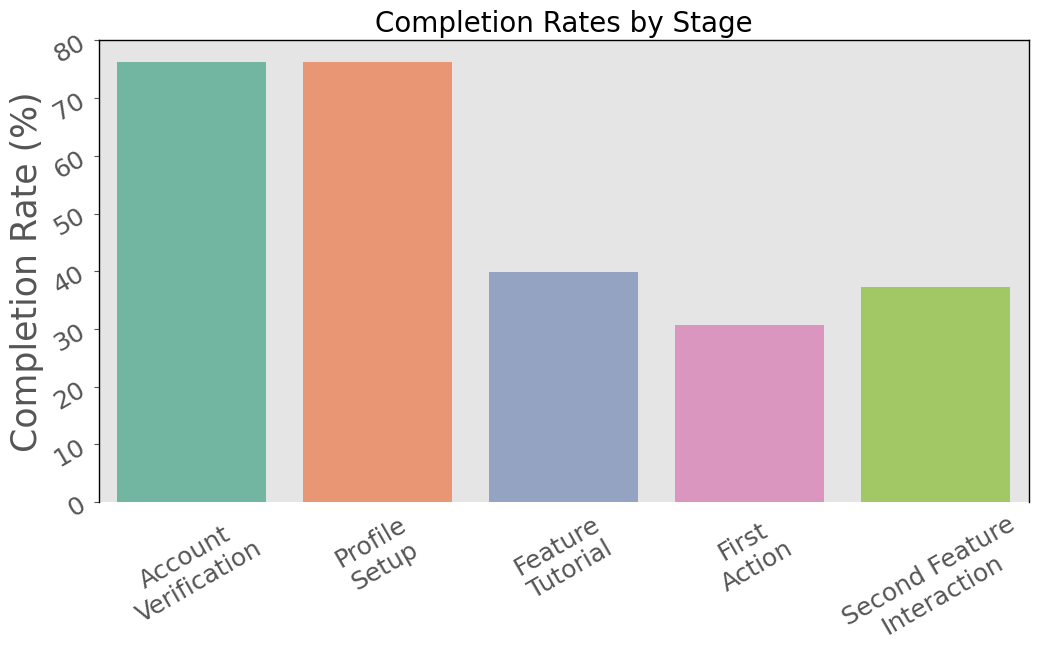

In [191]:
stage_data = {'account verification rate': [account_verification_rate],
            'Profile setup rate': [profile_setup_rate] ,
            'Feature Tutorial Rate': [feat_tuto_rate] ,
            'First Action rate': [first_action_taken_rate] ,
            'Second Feature Interaction Rate': [second_feature_interaction_rate]}

stage_completion_rate = pd.DataFrame(stage_data) 

stage_completion_rate = pd.melt(stage_completion_rate, var_name='Stage', value_name='Completion Rate (%)')


# Create the figure with a single subplot
fig, ax = plt.subplots(figsize=(12, 6))
xticks_positions = [0,1, 2, 3, 4]
ax.set_xticks(xticks_positions)
# Plot the bar chart with different colors
ax = sns.barplot(x='Stage', y='Completion Rate (%)', data=stage_completion_rate, hue='Stage', legend=False, palette='Set2')
ax.set_title('Completion Rates by Stage', fontsize=20)
ax.set_xlabel(None)
ax.tick_params(bottom=False, left=True, labelsize=18, rotation=30)
ax.set_ylabel('Completion Rate (%)', fontsize=25)

# Hide the bottom spine
ax.spines['bottom'].set_visible(False)
ax.grid(False)

# Set black color for spines
for _, s in ax.spines.items():
    s.set_color('black')

# Adjust the x-axis tick labels
ax.set_xticklabels(['Account\nVerification', 'Profile\nSetup', 'Feature\nTutorial', 'First\nAction', 'Second Feature\nInteraction'])

     #### Drop-off steps: Analyze at which steps users are dropping off by calculating the completion rates ##


In [17]:

  ### Let's see the compelation rate between steps.

## Email verificaion rate   
total_email_started = user_df[~user_df['email_verification_sta'].isna()]
total_email_started_count = total_email_started.shape[0]

# Calculate the verification rate
email_verification_rate = (email_verified_count / total_email_started_count) * 100

## Profile Setup rate
total_profi_started = user_df[~user_df['profile_setup_sta'].isna()]
total_profile_started_count = total_profi_started.shape[0]
profile_setupp_rate = (profil_set_com_count / total_profile_started_count) * 100

## Feature Tutorial rate
total_feat_started = user_df[~user_df['feature_tuto_sta'].isna()]
total_feat_started_count = total_feat_started.shape[0]
feat_tutoo_rate = (feat_tut_com_count / total_feat_started_count) * 100

## First actio taken/feature tutorial completed
first_feat_intro_count = user_df[~user_df['first_feat_intro'].isna()]
first_feat_intro_count_total= first_feat_intro_count.shape[0]
first_act_take_rate = (first_action_taken_count / first_feat_intro_count_total) * 100

## Secondady feature interaction/ introduction     
successful_completions = user_df[user_df['sec_fea_interaction'] == 1].shape[0] 
sec_feaa_count_total = user_df[user_df['sec_fea_intro'] == 1].shape[0]
second_feature_interact_rate = (successful_completions / sec_feaa_count_total) * 100

### Visualization of Completion Rates by Step


[Text(0, 0, 'Email\nVerification\nComp'),
 Text(1, 0, 'Profile\nSetup\nComp'),
 Text(2, 0, 'Feature\nTutorial\nComp'),
 Text(3, 0, 'First\nAction\nComp'),
 Text(4, 0, 'Second Feature\nInteraction\nComp')]

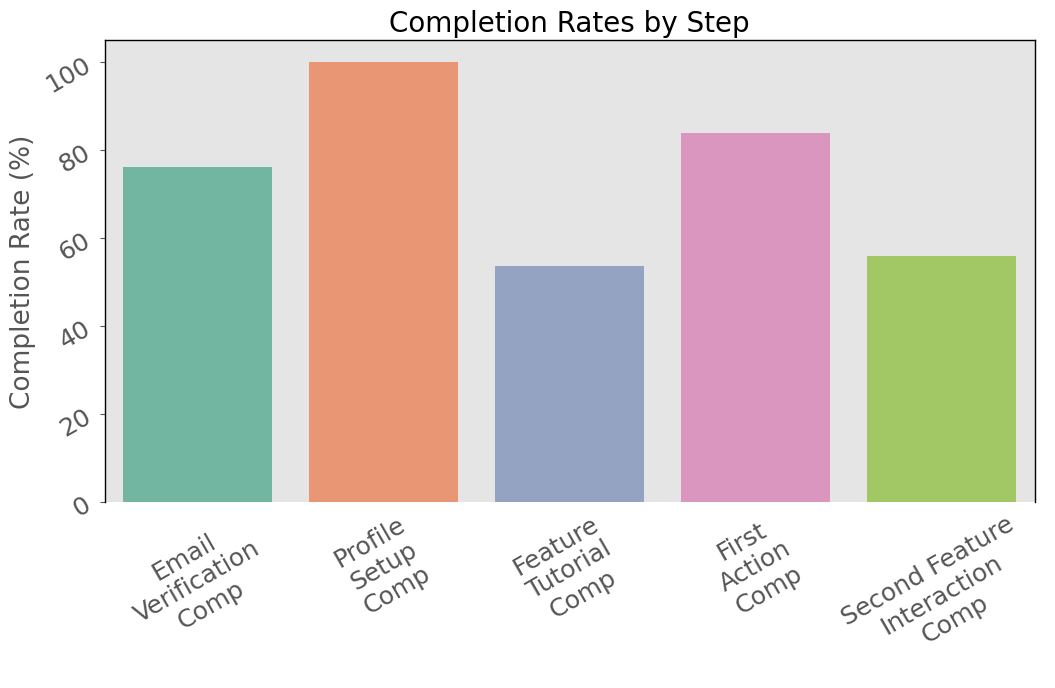

In [192]:
step_data = {'Email verification Comp': [email_verification_rate],
            'Profile setup Comp': [profile_setupp_rate] ,
            'Feature Tutorial Comp': [feat_tutoo_rate] ,
            'First Action Comp': [first_act_take_rate] ,
            'Second Feature Interaction Comp': [second_feature_interact_rate]}


step_completion_rate = pd.DataFrame(step_data) 

step_completion_rate = pd.melt(step_completion_rate, var_name='Step', value_name='Completion Rate (%)')


# Create the figure with a single subplot
fig, ax = plt.subplots(figsize=(12, 6))

xticks_positions = [0,1, 2, 3, 4]
ax.set_xticks(xticks_positions)

# Plot the bar chart with different colors
ax = sns.barplot(x='Step', y='Completion Rate (%)', data=step_completion_rate, hue='Step', legend=False, palette='Set2')
ax.set_title('Completion Rates by Step', fontsize=20)
ax.set_xlabel(None)
ax.tick_params(bottom=False, left=True, labelsize=18, rotation=30)
ax.set_ylabel('Completion Rate (%)', fontsize=19)

# Hide the bottom spine
ax.spines['bottom'].set_visible(False)
ax.grid(False)

# Set black color for spines
for _, s in ax.spines.items():
    s.set_color('black')

# Adjust the x-axis tick labels
ax.set_xticklabels(['Email\nVerification\nComp', 'Profile\nSetup\nComp', 'Feature\nTutorial\nComp', 'First\nAction\nComp', 'Second Feature\nInteraction\nComp'])


     ### Grouping the data by various attributes (geographics, signup source, subscription type) and analyzing the completion rates for each group 


In [29]:
## Account Verification rate

# Define a function to calculate and return the completion rate Series
def calculate_completion_rate(group):
  # Filter for users who started profile setup (not null) # we assume they are the once who completed the email verification
  email_verifiedd = group[~group['email_verification_com'].isna()]
  
  # Count users who completed profile setup (not NaT)
  email_verifiedd_count = email_verifiedd[~email_verifiedd['email_verification_com'].isna()].shape[0]

  # Count total users who started profile setup
  total_users = user_df.shape[0]
  
  # Calculate and return completion rate
  if total_users > 0:  # Avoid division by zero
    completion_rate = (email_verifiedd_count / total_users) * 100
  else:
    completion_rate = 0  # Set completion rate to 0 if no users started
  return completion_rate

  # Return the Series containing completion rates for the group
  return group['completion_rate']

# Group the DataFrame by 'geographics'
grouped_geo = user_df.groupby(['geographics'])

#Apply the function and store the result in a new DataFrame
account_rates_geo = grouped_geo.apply(calculate_completion_rate, include_groups=False) 
print(account_rates_geo)

# Group the DataFrame by 'Signup source'
grouped_sign = user_df.groupby(['sign_source'])

# Apply the function and store the result in a new DataFrame
account_rates_sign= grouped_sign.apply(calculate_completion_rate, include_groups=False)
print(account_rates_sign)

# Group the DataFrame by 'subscription type'
grouped_sub = user_df.groupby(['sub_type'])

# Apply the function and store the result in a new DataFrame
account_rates_sub= grouped_sub.apply(calculate_completion_rate, include_groups=False)
print(account_rates_sub)

#### profile setup rates


# Define a function to calculate and return the completion rate Series
def calculate_prof_rate(group):
  # Filter for users who started profile setup (not null)
  prof_set_compl = group[~group['profile_setup_com'].isna()]
  
  # Count users who completed profile setup (not NaT)
  prof_set_comp_count = prof_set_compl[~prof_set_compl['profile_setup_com'].isna()].shape[0]

  # Count total users who started profile setup
  total_users = user_df.shape[0]

  
  # Calculate and return completion rate
  if total_users > 0:  # Avoid division by zero
    prof_rate = (prof_set_comp_count / total_users) * 100
  else:
    prof_rate = 0  # Set completion rate to 0 if no users started
  return prof_rate

  # Return the Series containing completion rates for the group
  return group['prof_rate']

# Group DataFrame by 'geographics'
grouped_pro_geo = user_df.groupby(['geographics'])

# Apply the function and store the result in a new DataFrame
prof_set_rates_geo = grouped_pro_geo.apply(calculate_prof_rate, include_groups=False) 
print(prof_set_rates_geo)

# Group DataFrame by 'signup source'
grouped_pro_sign = user_df.groupby(['sign_source'])

# Apply the function and store the result in a new DataFrame
prof_set_rates_sign = grouped_pro_sign.apply(calculate_prof_rate, include_groups=False) 
print(prof_set_rates_sign)

# Group DataFrame by 'subscription type'
grouped_pro_sub = user_df.groupby(['sub_type'])

# Apply the function and store the result in a new DataFrame
prof_set_rates_sub = grouped_pro_sub.apply(calculate_prof_rate, include_groups=False) 
print(prof_set_rates_sub)


#### Feature Tuto rates


# Define a function to calculate and return the completion rate Series
def calculate_feat_rate(group):
  # Filter for users who started profile setup (not null)
  feat_tut_compl = group[~group['feature_tuto_com'].isna()]
  
  # Count users who completed profile setup (not NaT)
  feat_tut_compl_count = feat_tut_compl[~feat_tut_compl['feature_tuto_com'].isna()].shape[0]

  # Count total users who started profile setup
  total_users = user_df.shape[0]

  
  # Calculate and return completion rate
  if total_users > 0:  # Avoid division by zero
    feat_rate = (feat_tut_compl_count / total_users) * 100
  else:
    feat_rate = 0  # Set completion rate to 0 if no users started
  return feat_rate

  # Return the Series containing completion rates for the group
  return group['feat_rate']

# Group DataFrame by ' geographics'
grouped_fea_geo = user_df.groupby(['geographics'])
# Apply the function and store the result in a new DataFrame
feat_rates_geo = grouped_fea_geo.apply(calculate_feat_rate, include_groups=False)
print(feat_rates_geo) 

# Group DataFrame by 'signup source'
grouped_fea_sign= user_df.groupby(['sign_source'])
# Apply the function and store the result in a new DataFrame
feat_rates_sign = grouped_fea_sign.apply(calculate_feat_rate, include_groups=False) 
print(feat_rates_sign)

# Group DataFrame by ' susbscription type'
grouped_fea_sub = user_df.groupby(['sub_type'])
# Apply the function and store the result in a new DataFrame
feat_rates_sub = grouped_fea_sub.apply(calculate_feat_rate, include_groups=False) 
print(feat_rates_sub)


#### First Action Taken rates

# Define a function to calculate and return the completion rate Series
def calculate_fa_rate(group):
  # Filter for users who started profile setup (not null)
  fa = group[~group['first_act_tak'].isna()]
  
  # Count users who completed profile setup (not NaT)
  fa_count = fa[~fa['first_act_tak'].isna()].shape[0]

  # Count total users who started profile setup
  total_users = user_df.shape[0]

  
  # Calculate and return completion rate
  if total_users > 0:  # Avoid division by zero
    fa_rate = (fa_count / total_users) * 100
  else:
    fa_rate = 0  # Set completion rate to 0 if no users started
  return fa_rate

  # Return the Series containing completion rates for the group
  return group['fa_rate']

# Groupe DF by "Geographics"
grouped_first_act_geo = user_df.groupby(['geographics'])
# Apply the function and store the result in a new DataFrame
first_action_rates_geo = grouped_first_act_geo.apply(calculate_fa_rate, include_groups=False) 
print(first_action_rates_geo)

# Groupe DF by "signup source"
grouped_first_act_sign = user_df.groupby(['sign_source'])
# Apply the function and store the result in a new DataFrame
first_action_rates_sign = grouped_first_act_sign.apply(calculate_fa_rate, include_groups=False) 
print(first_action_rates_sign)

# Groupe DF by "subscription type"
grouped_first_act_sub = user_df.groupby(['sub_type'])
# Apply the function and store the result in a new DataFrame
first_action_rates_sub = grouped_first_act_sub.apply(calculate_fa_rate, include_groups=False) 
print(first_action_rates_sub)

#### Secondary Feature Interaction rates


# Define a function to calculate and return the completion rate Series
def calculate_sec_fea_rate(group):
  # Filter for users who started profile setup (not null)
  sec_fea_count= group[group['sec_fea_interaction'] == 1].shape[0]
  
  # Count total users who started profile setup
  total_users = user_df.shape[0]


  # Calculate and return completion rate
  if total_users > 0:  # Avoid division by zero
    sec_fea_rate = (sec_fea_count / total_users) * 100
  else:
    sec_fea_rate = 0  # Set completion rate to 0 if no users started
  return sec_fea_rate

  # Return the Series containing completion rates for the group
  return group['sec_fea_rate']

# Group DF by 'geographics'
grouped_sec_fea_geo = user_df.groupby(['geographics'])
# Apply the function and store the result in a new DataFrame
sec_fea_rates_geo = grouped_sec_fea_geo.apply(calculate_sec_fea_rate, include_groups=False) 
print(sec_fea_rates_geo)

# Group DF by 'signup source'
grouped_sec_fea_sign = user_df.groupby(['sign_source'])
# Apply the function and store the result in a new DataFrame
sec_fea_rates_sign = grouped_sec_fea_sign.apply(calculate_sec_fea_rate, include_groups=False) 
print(sec_fea_rates_sign)

# Group DF by 'subscription type'
grouped_sec_fea_sub = user_df.groupby(['sub_type'])
# Apply the function and store the result in a new DataFrame
sec_fea_rates_sub = grouped_sec_fea_sub.apply(calculate_sec_fea_rate, include_groups=False) 
print(sec_fea_rates_sub)


geographics
AUSTRALIA    16.065574
EUROPE       14.262295
JAPAN        15.409836
UK           16.229508
USA          14.262295
dtype: float64
sign_source
Advertisement    19.016393
Referral         18.032787
Social Media     20.000000
Website          19.180328
dtype: float64
sub_type
Basic         21.475410
Business      19.016393
Enterprise    18.032787
Pro           17.704918
dtype: float64
geographics
AUSTRALIA    16.065574
EUROPE       14.262295
JAPAN        15.409836
UK           16.229508
USA          14.262295
dtype: float64
sign_source
Advertisement    19.016393
Referral         18.032787
Social Media     20.000000
Website          19.180328
dtype: float64
sub_type
Basic         21.475410
Business      19.016393
Enterprise    18.032787
Pro           17.704918
dtype: float64
geographics
AUSTRALIA    7.377049
EUROPE       9.508197
JAPAN        8.360656
UK           8.524590
USA          6.065574
dtype: float64
sign_source
Advertisement     9.344262
Referral          9.508197
Soc

### Visualization of Stage completion rates Grouped by {Georgraphics, Signup Source, Subscription Type}


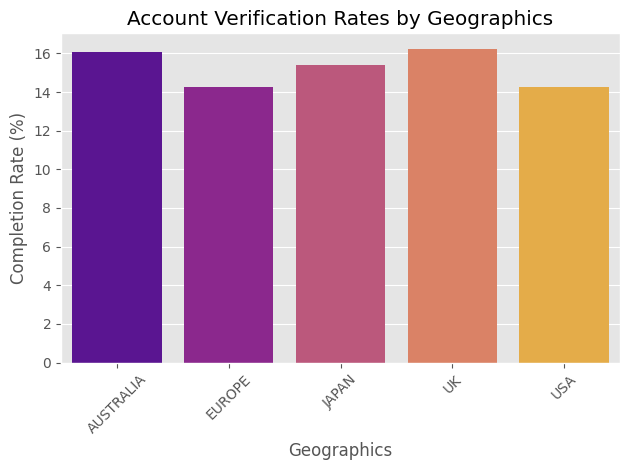

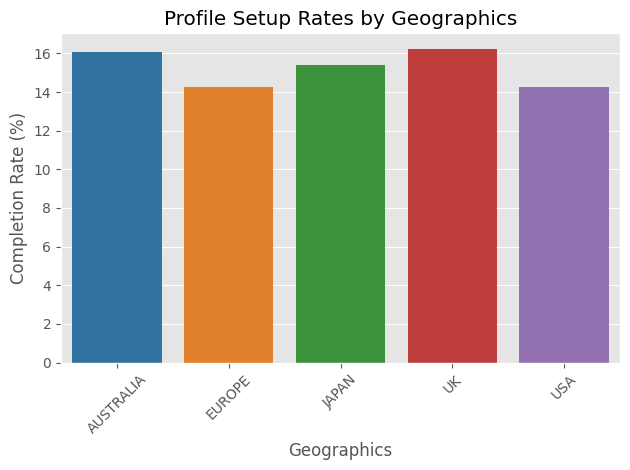

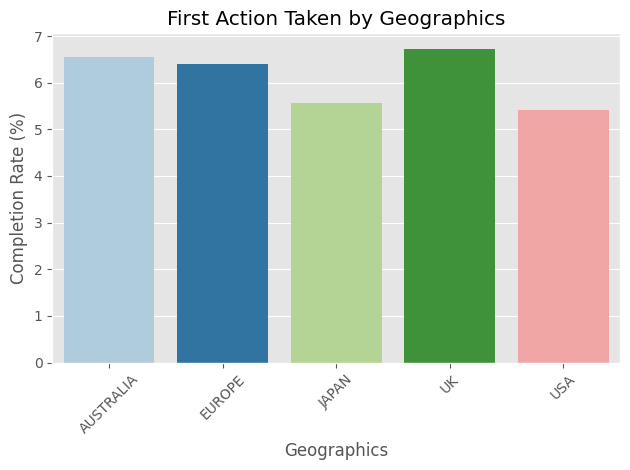

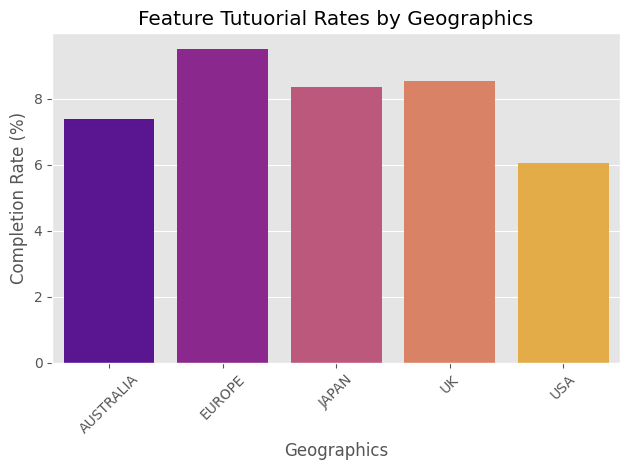

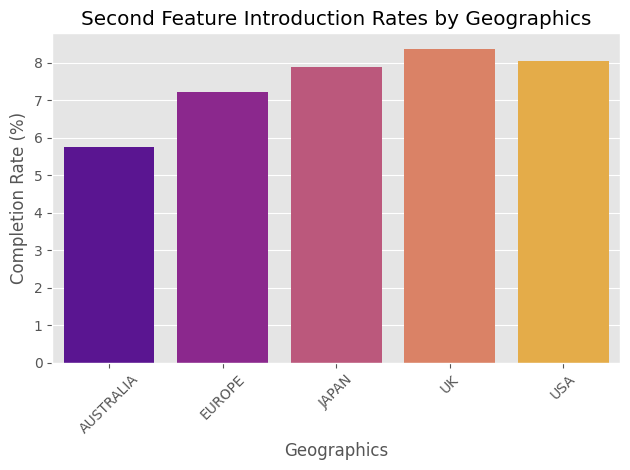

In [159]:
rates_dff = pd.DataFrame({
    'Account Verification Rate': [account_rates_geo],
    'Profile Setup Rate': [prof_set_rates_geo],
    'First Action Rate': [first_action_rates_geo],
    'Feature Tutorial Rate': [feat_rates_geo],
    'Second Feature Rate': [sec_fea_rates_geo]
    
})

## Account Verification
sns.barplot(x=account_rates_geo.index, y=account_rates_geo.values, hue= account_rates_geo.index, legend= False, palette="plasma")  # Access index for x-axis labels
plt.title('Account Verification Rates by Geographics')
plt.xlabel('Geographics')
plt.ylabel('Completion Rate (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

## Profile Setup Verification
sns.barplot(x=prof_set_rates_geo.index, y=prof_set_rates_geo.values, hue= prof_set_rates_geo.index, legend=False, palette="tab10")  # Access index for x-axis labels
plt.title('Profile Setup Rates by Geographics')
plt.xlabel('Geographics')
plt.ylabel('Completion Rate (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

## First Action Taken 
sns.barplot(x=first_action_rates_geo.index, y=first_action_rates_geo.values, hue=first_action_rates_geo.index, legend=False, palette="Paired")  # Access index for x-axis labels
plt.title('First Action Taken by Geographics')
plt.xlabel('Geographics')
plt.ylabel('Completion Rate (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

## Feature Turorial 
sns.barplot(x=feat_rates_geo.index, y=feat_rates_geo.values, hue=feat_rates_geo.index, legend=False, palette="plasma")  # Access index for x-axis labels
plt.title('Feature Tutuorial Rates by Geographics')
plt.xlabel('Geographics')
plt.ylabel('Completion Rate (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

## Second Feature
sns.barplot(x=sec_fea_rates_geo.index, y=sec_fea_rates_geo.values, hue=sec_fea_rates_geo.index, legend=False,  palette="plasma")  # Access index for x-axis labels
plt.title('Second Feature Introduction Rates by Geographics')
plt.xlabel('Geographics')
plt.ylabel('Completion Rate (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

### Visualize all Stages rates Grouped by Geographics, Signup source, Subscription Type 


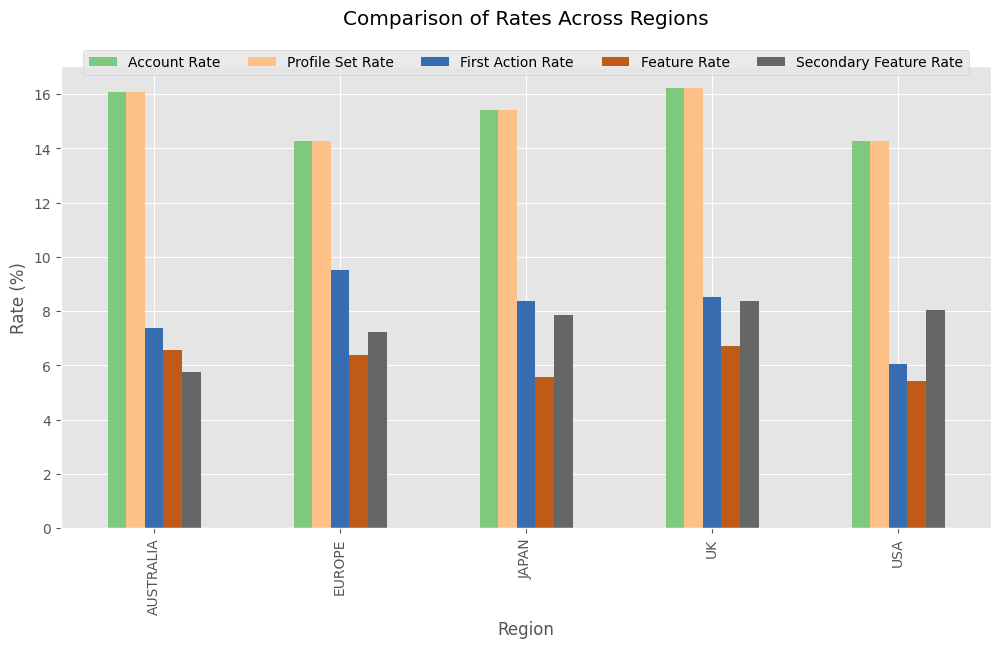

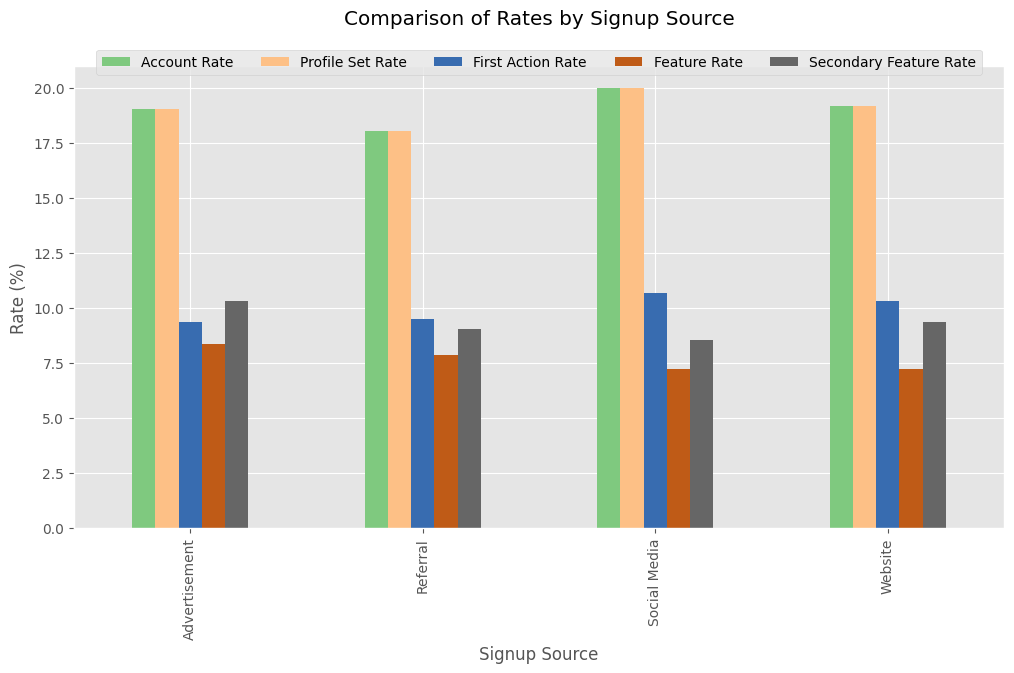

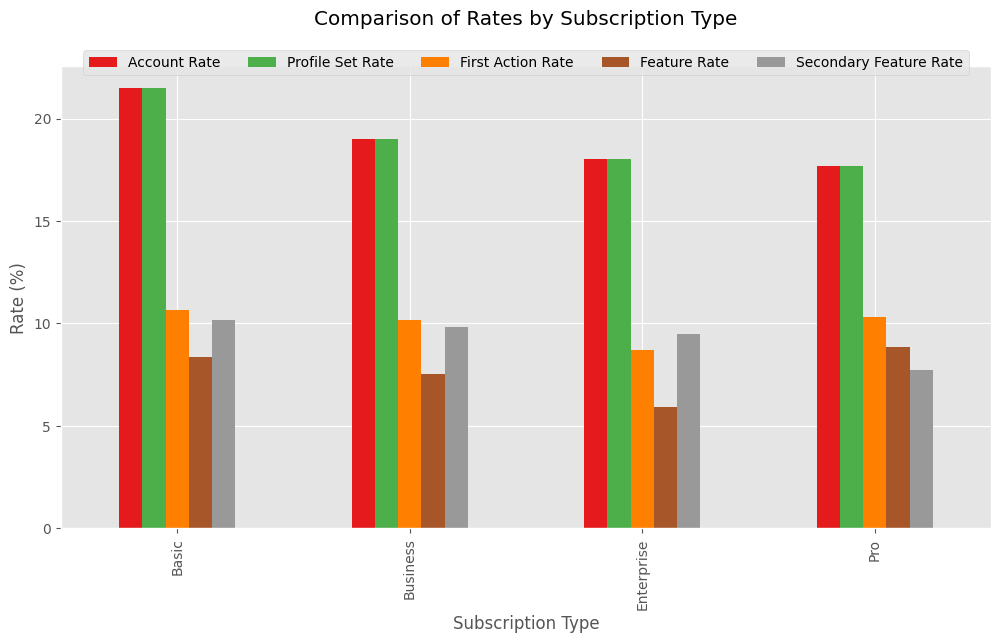

In [161]:

all_rates_geo = pd.concat([account_rates_geo, prof_set_rates_geo, feat_rates_geo,
                          first_action_rates_geo, sec_fea_rates_geo], axis=1)

all_rates_sign = pd.concat([account_rates_sign, prof_set_rates_sign, feat_rates_sign,
                           first_action_rates_sign, sec_fea_rates_sign], axis=1)

all_rates_sub = pd.concat([account_rates_sub, prof_set_rates_sub, feat_rates_sub,
                          first_action_rates_sub, sec_fea_rates_sub], axis=1)

# Rename the columns for clarity 

new_geo = ['Account Rate', 'Profile Set Rate', 
                         'First Action Rate', 'Feature Rate', 'Secondary Feature Rate']

new_sign = ['Account Rate', 'Profile Set Rate', 
                         'First Action Rate', 'Feature Rate', 'Secondary Feature Rate']

new_sub = ['Account Rate', 'Profile Set Rate', 
                         'First Action Rate', 'Feature Rate', 'Secondary Feature Rate']

all_rates_geo.columns = new_geo
all_rates_sign.columns = new_sign
all_rates_sub.columns = new_sub


# Visualize Comparison of rates across regions

fig, ax = plt.subplots(figsize=(12,6))
all_rates_geo.plot(kind='bar', ax=ax, colormap='Accent')

# Adjust the title and legend position
plt.title('Comparison of Rates Across Regions', pad=30)
plt.xlabel('Region')
plt.ylabel('Rate (%)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=5)

plt.show()

#Visualize Comparison of rates by Signup source
fig, ax = plt.subplots(figsize=(12,6))
all_rates_sign.plot(kind='bar', ax=ax, colormap='Accent')

# Adjust the title and legend position
plt.title('Comparison of Rates by Signup Source', pad=30)
plt.xlabel('Signup Source')
plt.ylabel('Rate (%)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=5)

plt.show()

#Visualize Comparison of rates by Subscription type
fig, ax = plt.subplots(figsize=(12,6))
all_rates_sub.plot(kind='bar', ax=ax, colormap='Set1')

# Adjust the title and legend position
plt.title('Comparison of Rates by Subscription Type', pad=30)
plt.xlabel('Subscription Type')
plt.ylabel('Rate (%)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=5)

plt.show()

## Calculate the durations

In [34]:

filtred_dataframe = df.dropna(subset= ['profile_setup_sta', 'profile_setup_com',
                                      'email_verification_com', 'email_verification_sta',
                                      'feature_tuto_sta', 'first_act_tak',
                                      'feature_tuto_com', 'first_feat_intro'])

#Tutorial Duration
tutorial_duration = ((filtred_dataframe['feature_tuto_com'] - filtred_dataframe['feature_tuto_sta']).dt.total_seconds() / 60)
print(tutorial_duration)
                                                    
user_df.loc[:,'tutorial_duration'] = tutorial_duration # we add it to our dataframe for future usage

# Email Verification Duration in minutes
email_verifi_duration = ((filtred_dataframe['email_verification_com'] - filtred_dataframe['email_verification_sta']).dt.total_seconds() / 60)
print(email_verifi_duration)

# Profile Setup Duration in minutes
profile_setup_duration = (filtred_dataframe['profile_setup_com'] - filtred_dataframe['profile_setup_sta']).dt.total_seconds() / 60
print(profile_setup_duration)

# Feature Tutorial Duration in minutes
feature_tuto_duration = (filtred_dataframe['feature_tuto_com'] - filtred_dataframe['feature_tuto_sta']).dt.total_seconds() / 60
print(feature_tuto_duration)

# First Action Duration in minutes
first_action_duration = (filtred_dataframe['first_act_tak'] - filtred_dataframe['first_feat_intro']).dt.total_seconds() / 60

1      29.690767
3      26.329267
5      29.035933
7      28.049917
9      28.127233
         ...    
347    28.426733
349    27.070333
351    25.904917
353    26.185700
355    25.008783
Length: 178, dtype: float64
7.452131928838952
1      17.307500
3      15.353750
5      15.948600
7      18.625317
9      19.630933
         ...    
347    17.210967
349    16.168450
351    16.419383
353    17.131967
355    19.638033
Length: 178, dtype: float64
1      29.690767
3      26.329267
5      29.035933
7      28.049917
9      28.127233
         ...    
347    28.426733
349    27.070333
351    25.904917
353    26.185700
355    25.008783
Length: 178, dtype: float64


In [37]:
duration_df = pd.DataFrame({'Tutorial Duration': tutorial_duration, 
                            'Profile Setup Duration': profile_setup_duration,
                            'Email Verification Duration': email_verifi_duration,
                            'Feature Tutorial Duration': feature_tuto_duration,
                            'First Action Duration': first_action_duration})
print(duration_df.head(5))

   Tutorial Duration  Profile Setup Duration  Email Verification Duration  \
1          29.690767               17.307500                     7.452132   
3          26.329267               15.353750                     7.452132   
5          29.035933               15.948600                     7.452132   
7          28.049917               18.625317                     7.452132   
9          28.127233               19.630933                     7.452132   

   Feature Tutorial Duration  First Action Duration  
1                  29.690767               1.996100  
3                  26.329267               1.499583  
5                  29.035933               2.701317  
7                  28.049917               1.982800  
9                  28.127233               2.016750  


# Visualization of duration

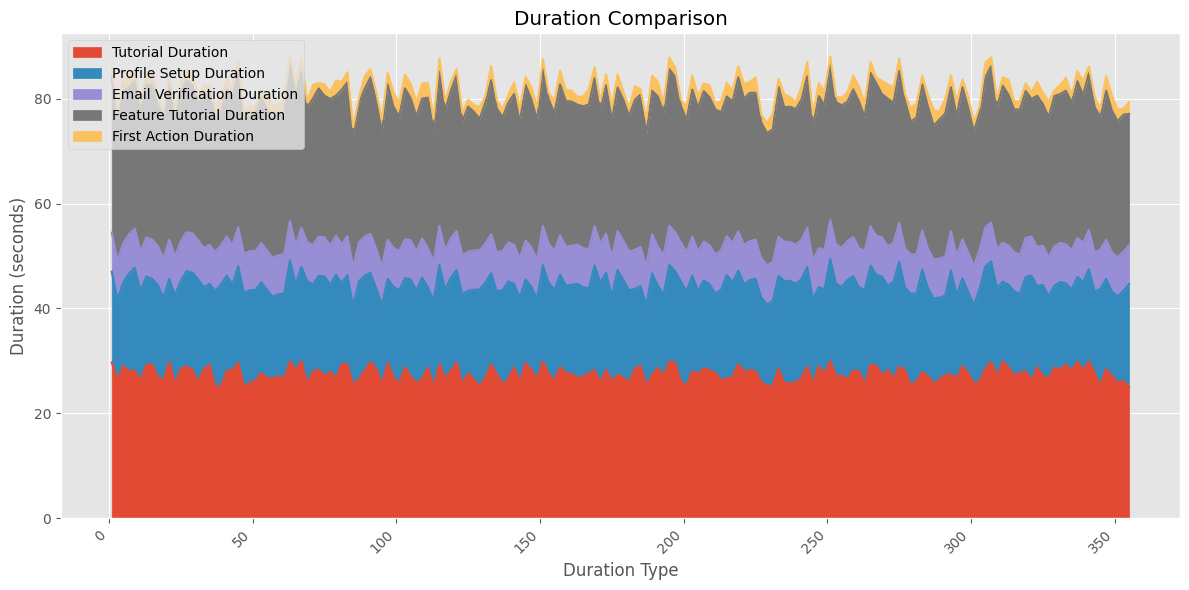

In [38]:
# Create the stacked area chart
fig, ax = plt.subplots(figsize=(12, 6))
duration_df.plot(kind='area', stacked=True, ax=ax)

plt.title('Duration Comparison')

plt.xlabel('Duration Type')
plt.ylabel('Duration (seconds)')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## Visualization of Email Verification by Month 


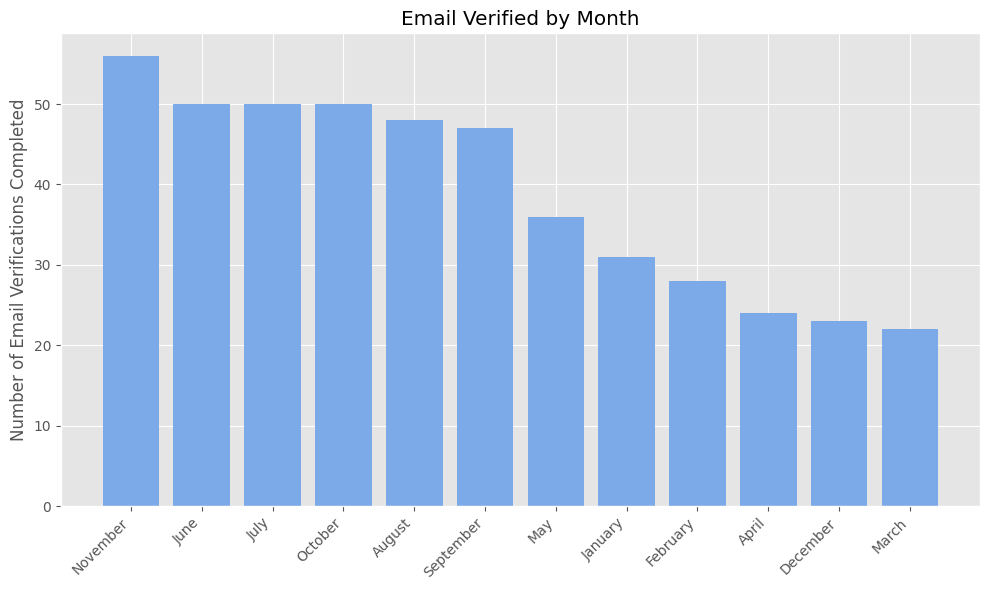

In [42]:
df_datetime = pd.DataFrame(user_df)

# Extract month from the datetime column
df_datetime['month_name'] = df_datetime['email_verification_com'].dt.month_name()

# Count verifications by month
verification_counts = df_datetime['month_name'].value_counts()

# Create a bar chart to visualize monthly verifications
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(verification_counts.index, verification_counts.values, color='#7CAAE8')
plt.xlabel('')
plt.ylabel('Number of Email Verifications Completed')
plt.title('Email Verified by Month')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

## Visualization of First Action Taken by Month 

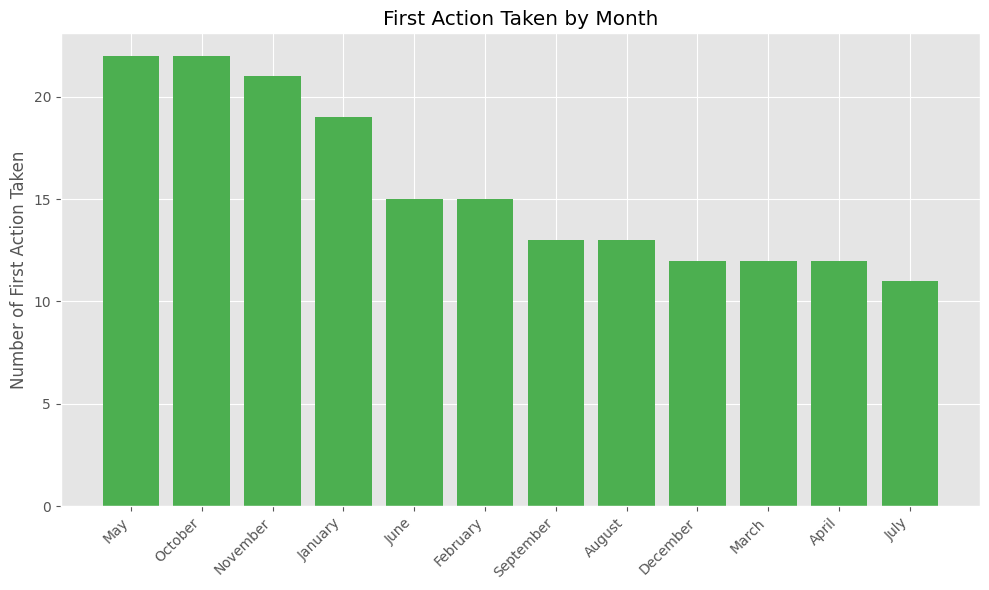

In [44]:
df_datetime['month_name2'] = df_datetime['first_act_tak'].dt.month_name()

# Count verifications by month
first_action_counts = df_datetime['month_name2'].value_counts()

# Create a bar chart to visualize monthly verifications
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(first_action_counts.index, first_action_counts.values, color='#4CAF50')
plt.xlabel('')
plt.ylabel('Number of First Action Taken')
plt.title('First Action Taken by Month')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()


## Visualization of Support Pages views


In [182]:
user_df.columns

Index(['user_id', 'is_new_user', 'account_creation_initiated', 'reg_date',
       'email_verification_sta', 'email_verification_com', 'profile_setup_sta',
       'profile_setup_com', 'feature_tuto_sta', 'feature_tuto_com',
       'first_feat_intro', 'first_act_tak', 'sec_fea_intro',
       'sec_fea_interaction', 'getting_sta', 'acc_manag', 'aud_vid',
       'integration', 'geographics', 'sign_source', 'sub_type', 'feed_score'],
      dtype='object')

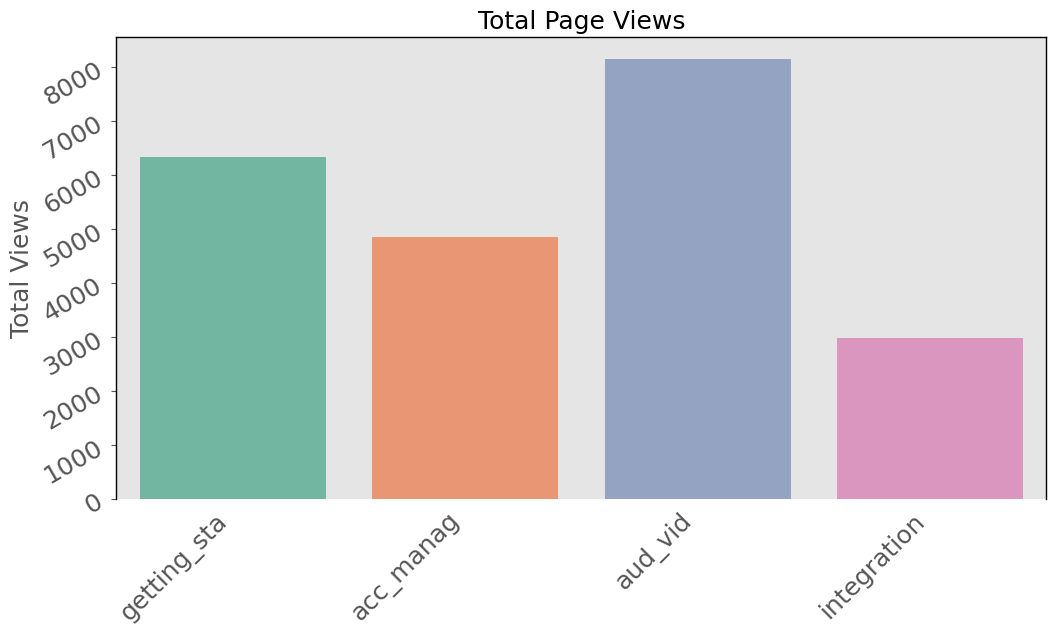

In [193]:
page_views = user_df[['getting_sta', 'acc_manag', 'aud_vid', 'integration']]
#rename the columns
page_views = page_views.rename(columns={'getting_sta': 'Getting Started',
                                       'acc_manag': 'Account Management',
                                       'aud_vid': 'Aud & Video',
                                       'integration': 'Integration'})


fig, ax = plt.subplots(figsize=(12, 6))

# Calculate the total views for each column
total_views = page_views.sum()

# Plot the bar chart with different colors
xticks_positions = [0,1, 2, 3]
ax.set_xticks(xticks_positions)
ax = sns.barplot(x=total_views.index, y=total_views, hue=total_views.index, legend=False, palette='Set2')
ax.set_title('Total Page Views', fontsize=18)
ax.set_xlabel(None)
ax.tick_params(bottom=False, left=True, labelsize=18, rotation=30)
ax.set_ylabel('Total Views', fontsize=18
             )

# Hide the bottom spine
ax.spines['bottom'].set_visible(False)
ax.grid(False)

# Set black color for spines
for _, s in ax.spines.items():
    s.set_color('black')

# Adjust the x-axis tick labels
ax.set_xticklabels(['getting_sta', 'acc_manag', 'aud_vid', 'integration'], rotation = 45, ha = 'right')

plt.show()

## Visualization of Support pages views grouped by Subscription Type 


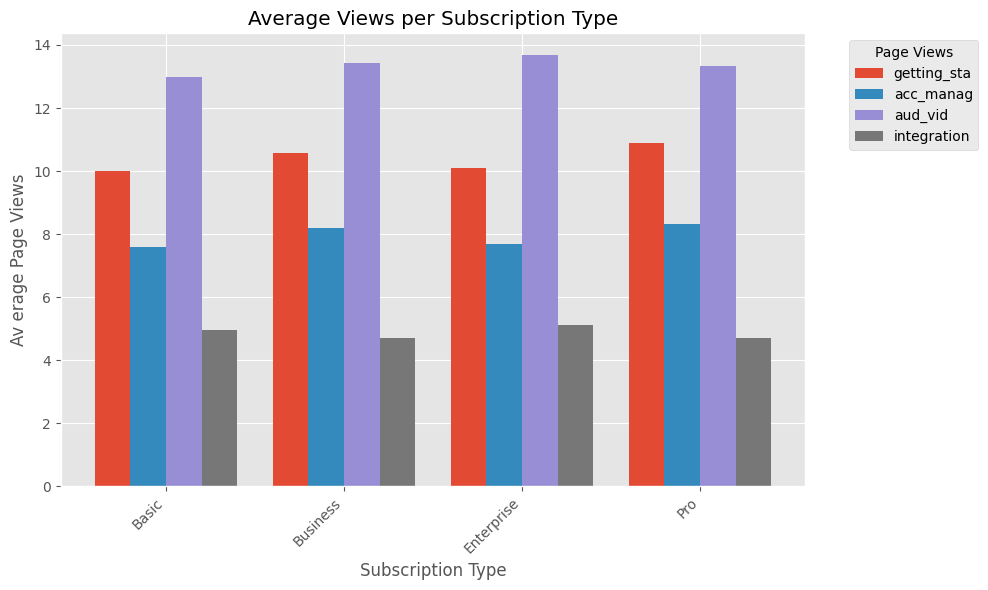

In [50]:
vis = user_df[['sub_type', 'getting_sta', 'acc_manag', 'aud_vid', 'integration']]

agg_vis = vis.groupby('sub_type').mean().reset_index()

fig, ax = plt.subplots(figsize = (10, 6))
bar_width = 0.2

positions = range(len(agg_vis))

for i, column in enumerate(['getting_sta', 'acc_manag', 'aud_vid', 'integration']):
  plt.bar([p + bar_width * i for p in positions], agg_vis[column], width= bar_width, label=column)


ax.set_xticks([p + 1.5 * bar_width for p in positions])
ax.set_xticklabels(agg_vis['sub_type'], rotation = 45, ha = 'right')

plt.xlabel('Subscription Type')
plt.ylabel('Av erage Page Views')
plt.title('Average Views per Subscription Type')
plt.legend(title= 'Page Views', bbox_to_anchor=(1.05, 1), loc= 'upper left')
plt.tight_layout()
plt.show()


#How many users give 1 star feedback ?

In [61]:
df_check = user_df[user_df['feed_score'] == 1 ]
print()
print(f'Total number of users  who gave 1 start feedback  : {len(df_check)}.')


Total number of users  who gave 1 start feedback  : 38.


# Create a function that returns a Pie chart for categorical variable:

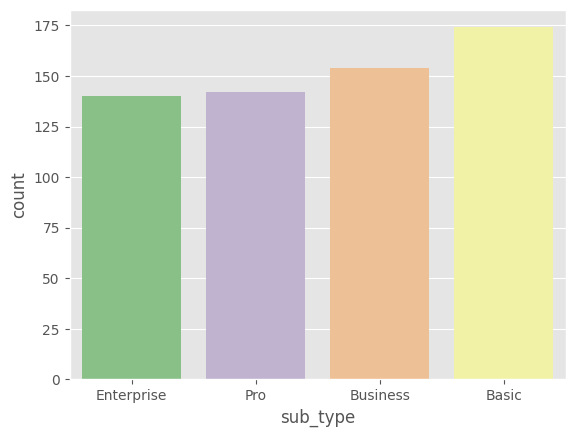

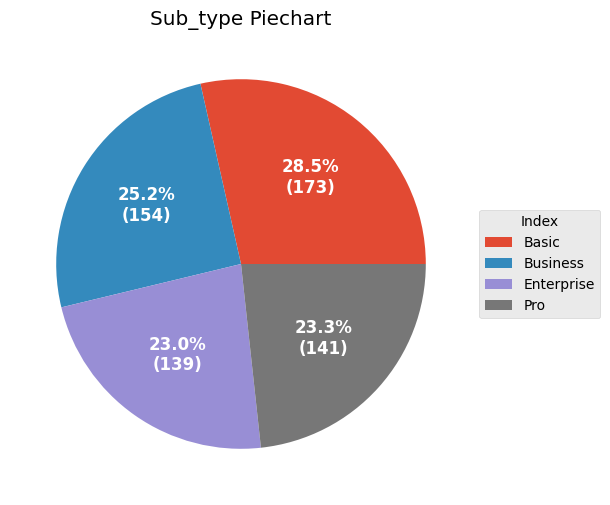

In [63]:
def pie_chart(x = 'is_new_user'):
    """
    Function creates a Pie chart for categorical variables.
    """
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(aspect="equal"))

    s = user_df.groupby(x).size()

    mydata_values = s.values.tolist()
    mydata_index = s.index.tolist()

    def func(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.1f}%\n({:d})".format(pct, absolute)


    wedges, texts, autotexts = ax.pie(mydata_values, autopct=lambda pct: func(pct, mydata_values),
                                      textprops=dict(color="w"))

    ax.legend(wedges, mydata_index,
              title="Index",
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))

    plt.setp(autotexts, size=12, weight="bold")

    ax.set_title(f'{x.capitalize()} Piechart')

    plt.show()

sns.countplot(x = 'sub_type', data = user_df, hue= 'sub_type', palette = 'Accent')

pie_chart('sub_type')

#Hypothesis testing

In [ ]:
returning_user = user_df[user_df['is_new_user'] == 0]
new_user = user_df[user_df['is_new_user'] == 1]
duration_return = returning_user['tutorial_duration']
duration_new = new_user['tutorial_duration']

print(f'Number of returning users: {returning_user.shape[0]}')
print(f'Variance in duartion of returning users: {np.var(duration_return)}')
print(f'Number of new users : {new_user.shape[0]}')
print(f'Variance in duration of new users: {np.var(duration_new)}')

t_statistic, p_value = ttest_ind(duration_return, duration_new, equal_var=False)
print(f't_statistic: {t_statistic}\np_value: {p_value}')

print ("two-sample t-test p-value=", p_value)

p_value > 0.05


#Visualizing the collected data:
g = sns.catplot(x="is_new_user", y="tutorial_duration", hue="sec_fea_interaction",
            kind="violin", inner="quartiles", split=True,
            palette="RdBu_r", data=user_df, legend_out = True);

xlabels = ['returning user', 'new user']
g.set_xticklabels(xlabels)

new_title = 'Second fea interaction'
g._legend.set_title(new_title)
g._legend.set_bbox_to_anchor([1.1, 0.5])
# replace labels
new_labels = ['Interacted', 'Didnt']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

print()

## Relationship between User Type and First action taken


first_act_tak    1
is_new_user       
0              295
1              315
Chi-square statistic: 0.0
P-value: 1.0
Degrees of Freedom: 0
With a p-value of 1.0 the difference is not significant. We fail to reject the Null Hypothesis


[Text(0, 0, 'return user'), Text(0, 1, 'new user')]

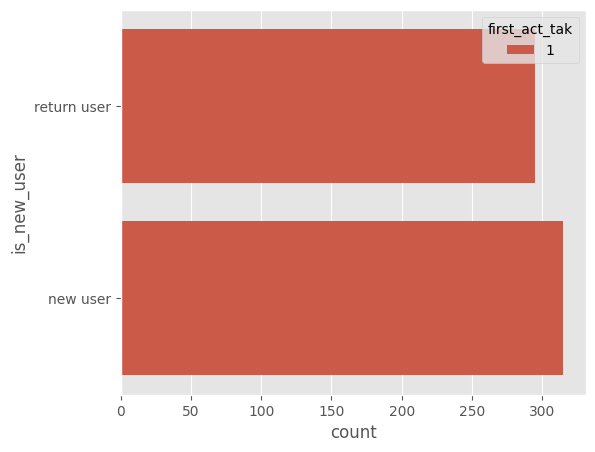

In [101]:
#Create a new binary column for 'First Action Taken'
user_df.loc[:, 'first_act_tak'] = user_df['first_act_tak'].apply(lambda x: 1 if pd.notnull(x) else 0)
returning_user = user_df[user_df['is_new_user'] == 0]
new_user = user_df[user_df['is_new_user'] == 1]

##Perform cross-tabulation
cross_table = pd.crosstab(user_df['is_new_user'], user_df['first_act_tak'])
print(cross_table)

## Conduct chi-square test
chi2, p_value, dof, expected = chi2_contingency(cross_table)

print('Chi-square statistic:', chi2)
print('P-value:', p_value)
print(f"Degrees of Freedom: {dof}")

if p_value < 0.05:
    print(f'With a p-value of {p_value} the difference is significant. We reject the Null Hypothesis.')
else:
    print(f'With a p-value of {p_value} the difference is not significant. We fail to reject the Null Hypothesis')

# Visualization of the collected data:
plt.figure(figsize=(6,5))

yticks_positions = [0, 1]
yticks_labels = ['return user', 'new user']

# Create a FixedLocator for the tick positions
locator = FixedLocator(yticks_positions)
chart = sns.countplot(y = 'is_new_user', hue = 'first_act_tak', data =user_df)

# Set the locator and labels in one step
chart.yaxis.set_major_locator(locator)
chart.set_yticklabels(yticks_labels)



## Difference in Tutorial Duration between User Segments


In [ ]:
segments = user_df['sub_type'].unique()
anova_result = f_oneway(*[user_df.loc[user_df['sub_type'] == seg, 'tutorial_duration'] for seg in segments])
print(f"ANOVA F-statistic: {anova_result.statistic:.2f}")
print(f"ANOVA p-value: {anova_result.pvalue:.4f}")#
###
print()

# Create the ANOVA model
model = sm.ols('first_act_tak ~ getting_sta + acc_manag + aud_vid + integration', data=user_df).fit()
anova_table = anova_lm(model, typ=2)

# Print the ANOVA table
print(anova_table)


## Relationship between User type and signup source

In [80]:
continge_table = pd.crosstab(user_df['is_new_user'], user_df['sign_source'])
chi2, p_value, dof, expected = chi2_contingency(continge_table)
print(f"Chi-Square Statistic: {chi2:.2f}")
print(f"p-value: {p_value:.4f}")
print(f"Degrees of Freedom: {dof}")

Chi-Square Statistic: 2.88
p-value: 0.4104
Degrees of Freedom: 3


## Difference in Tutorial Duration between User Segments


In [81]:
segments = user_df['sub_type'].unique()
anova_result = f_oneway(*[user_df.loc[user_df['sub_type'] == seg, 'tutorial_duration'] for seg in segments])
print(f"ANOVA F-statistic: {anova_result.statistic:.2f}")
print(f"ANOVA p-value: {anova_result.pvalue:.4f}")#
###
print()

# Create the ANOVA model
model = sm.ols('first_act_tak ~ getting_sta + acc_manag + aud_vid + integration', data=user_df).fit()
anova_table = anova_lm(model, typ=2)

# Print the ANOVA table
print(anova_table)

ANOVA F-statistic: 0.44
ANOVA p-value: 0.7270

                   sum_sq     df           F        PR(>F)
getting_sta  6.040455e-30    1.0  204.614388  3.422185e-40
acc_manag    2.797713e-30    1.0   94.769728  6.647215e-21
aud_vid      1.231295e-30    1.0   41.708906  2.177090e-10
integration  2.164692e-30    1.0   73.326782  9.098494e-17
Residual     1.786030e-29  605.0         NaN           NaN
